## Model:MLP, Dataset: EMNIST

**READ ME**

 Before running the code, make sure that data folder and code are in the same directory, and the data folder needs to contain four decompressed input files, which are named as ‘emnist-byclass-test-images-idx3-ubyte’, ‘emnist-byclass-test-labels-idx1-ubyte’, ‘emnist-byclass-train-images-idx3-ubyte’, ‘emnist-byclass-train-labels-idx1-ubyte’.
The code cells in the Setup and Preprocessing parts need to be run one by one. If you want to explore the whole building model step completely, you can run all the code cells in Build and tunning model one by one. If you only want to get the final tunned model, then you can run the summary module directly. Then run the complete prediction to predict on the test set.


## Setup

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
# To plot pretty figure
%matplotlib inline

keras.backend.clear_session()
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Data direction
train_data_dir='data/emnist-byclass-train-images-idx3-ubyte'
train_label_dir = 'data/emnist-byclass-train-labels-idx1-ubyte'
test_data_dir = 'data/emnist-byclass-test-images-idx3-ubyte'
test_label_dir = 'data/emnist-byclass-test-labels-idx1-ubyte'

# Read binary image data
def decode_idx3_ubyte(file):
    '''
    file: file dirction
    return: data set
    '''

    # read binary data
    bin_read_data = open(file,'rb').read()
    offset = 0
    header = '>iiii'
    magic_num, num_img, num_row, num_col = struct.unpack_from(header, bin_read_data,offset)
    print('magic number: %d, number of images: %d, image size: %d*%d' % (magic_num, num_img, num_row, num_col ))
    img_size = num_row * num_col
    offset += struct.calcsize(header)
    print(offset)
    fmt_image = '>' + str(img_size) + 'B'
    print(fmt_image, offset, struct.calcsize(fmt_image))
    images = np.empty((num_img, num_row, num_col))

    for i in range(num_img):
        if (i +1) % 10000 == 0:
            print('Decode: %d' % (i+1))
            print(offset)
        images[i] = np.array(struct.unpack_from(fmt_image, bin_read_data, offset)).reshape((num_row, num_col))
        offset += struct.calcsize(fmt_image)
    return images


# Read binary data
def decode_idx1_ubyte(file):
    '''
    file: file dirction
    return: data set
    '''
    bin_read_data = open(file, 'rb').read()
    offset = 0
    header = '>ii'
    magic_num, num_img = struct.unpack_from(header, bin_read_data,offset)
    print('magic number: %d, number of images: %d' % (magic_num, num_img))

    offset += struct.calcsize(header)
    fmt_img ='>B'
    labels = np.empty(num_img)
    for i in range(num_img):
        if (i + 1) % 10000 ==0:
            print('Decode: %d' %(i+1))
        labels[i] = struct.unpack_from(fmt_img,bin_read_data,offset)[0]
        offset += struct.calcsize(fmt_img)
    return labels

###  Data loading

In [2]:
trian_img_raw = decode_idx3_ubyte(train_data_dir)
test_img_raw = decode_idx3_ubyte(test_data_dir)

magic number: 2051, number of images: 697932, image size: 28*28
16
>784B 16 784
Decode: 10000
7839232
Decode: 20000
15679232
Decode: 30000
23519232
Decode: 40000
31359232
Decode: 50000
39199232
Decode: 60000
47039232
Decode: 70000
54879232
Decode: 80000
62719232
Decode: 90000
70559232
Decode: 100000
78399232
Decode: 110000
86239232
Decode: 120000
94079232
Decode: 130000
101919232
Decode: 140000
109759232
Decode: 150000
117599232
Decode: 160000
125439232
Decode: 170000
133279232
Decode: 180000
141119232
Decode: 190000
148959232
Decode: 200000
156799232
Decode: 210000
164639232
Decode: 220000
172479232
Decode: 230000
180319232
Decode: 240000
188159232
Decode: 250000
195999232
Decode: 260000
203839232
Decode: 270000
211679232
Decode: 280000
219519232
Decode: 290000
227359232
Decode: 300000
235199232
Decode: 310000
243039232
Decode: 320000
250879232
Decode: 330000
258719232
Decode: 340000
266559232
Decode: 350000
274399232
Decode: 360000
282239232
Decode: 370000
290079232
Decode: 380000
29

In [3]:
train_lab_raw = decode_idx1_ubyte(train_label_dir)
test_lab_raw = decode_idx1_ubyte(test_label_dir)

magic number: 2049, number of images: 697932
Decode: 10000
Decode: 20000
Decode: 30000
Decode: 40000
Decode: 50000
Decode: 60000
Decode: 70000
Decode: 80000
Decode: 90000
Decode: 100000
Decode: 110000
Decode: 120000
Decode: 130000
Decode: 140000
Decode: 150000
Decode: 160000
Decode: 170000
Decode: 180000
Decode: 190000
Decode: 200000
Decode: 210000
Decode: 220000
Decode: 230000
Decode: 240000
Decode: 250000
Decode: 260000
Decode: 270000
Decode: 280000
Decode: 290000
Decode: 300000
Decode: 310000
Decode: 320000
Decode: 330000
Decode: 340000
Decode: 350000
Decode: 360000
Decode: 370000
Decode: 380000
Decode: 390000
Decode: 400000
Decode: 410000
Decode: 420000
Decode: 430000
Decode: 440000
Decode: 450000
Decode: 460000
Decode: 470000
Decode: 480000
Decode: 490000
Decode: 500000
Decode: 510000
Decode: 520000
Decode: 530000
Decode: 540000
Decode: 550000
Decode: 560000
Decode: 570000
Decode: 580000
Decode: 590000
Decode: 600000
Decode: 610000
Decode: 620000
Decode: 630000
Decode: 640000
Deco

In [4]:
# See the structure of data
print('train data size: ',trian_img_raw.shape)
print('train label size: ',train_lab_raw.shape)

img_height = trian_img_raw.shape[1]
img_width = trian_img_raw.shape[2]
img_shape = img_height * img_width
print('image height: {}, image width: {}, image shape: {}'.format(img_height,img_width,img_shape))

train data size:  (697932, 28, 28)
train label size:  (697932,)
image height: 28, image width: 28, image shape: 784


## Preprocessing Data

### Scale data

In [5]:
# Scale the data to the range 0-1
X_train_norm = trian_img_raw/ 255.
print(X_train_norm.shape)
X_test_norm = test_img_raw/ 255.

(697932, 28, 28)


### Visualize the dataset

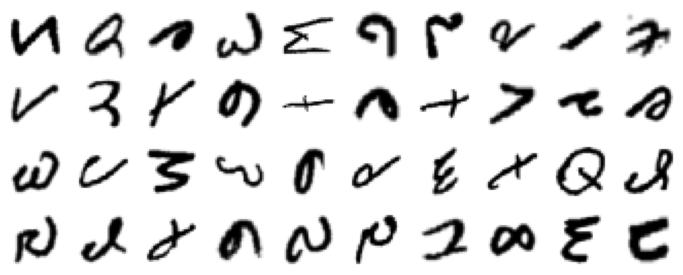

In [ ]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(X_train_norm)

### View all labels

In [ ]:
print(np.unique(train_lab_raw))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]
[35. 36.  6.  3. 22.]


### Split training set into training and validation set

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm,train_lab_raw,random_state=42)

## MLP model using Keras

##### Baseline model: one hidden layer with relu & sgd 

In [7]:
# Baseline model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')
])

2022-05-13 11:32:17.755625: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 62)                7998      
                                                                 
Total params: 108,478
Trainable params: 108,478
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Compile model with loss, optimiser, and metrics
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [9]:
# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 100
history = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/100
4090/4090 [==============================] - 14s 3ms/step - loss: 1.8160 - accuracy: 0.5628 - val_loss: 1.2767 - val_accuracy: 0.6567
Epoch 2/100
4090/4090 [==============================] - 9s 2ms/step - loss: 1.1794 - accuracy: 0.6773 - val_loss: 1.0939 - val_accuracy: 0.6960
Epoch 3/100
4090/4090 [==============================] - 8s 2ms/step - loss: 1.0567 - accuracy: 0.7054 - val_loss: 1.0070 - val_accuracy: 0.7173
Epoch 4/100
4090/4090 [==============================] - 8s 2ms/step - loss: 0.9820 - accuracy: 0.7231 - val_loss: 0.9438 - val_accuracy: 0.7315
Epoch 5/100
4090/4090 [==============================] - 8s 2ms/step - loss: 0.9249 - accuracy: 0.7367 - val_loss: 0.8937 - val_accuracy: 0.7444
Epoch 6/100
4090/4090 [==============================] - 8s 2ms/step - loss: 0.8786 - accuracy: 0.7477 - val_loss: 0.8529 - val_accuracy: 0.7534
Epoch 7/100
4090/4090 [==============================] - 8s 2ms/step - loss: 0.8404 - accuracy: 0.7568 - val_loss: 0.8183 - val_a

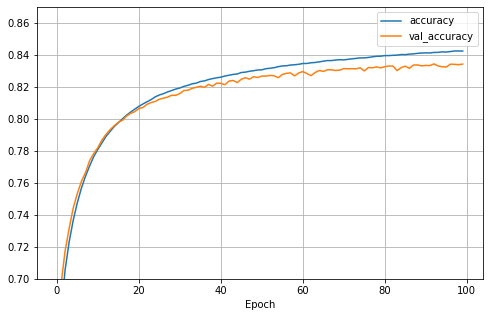

In [11]:
# plot the model accuracy
accuracies = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.7,0.87)
plt.xlabel('Epoch')
plt.show()

##### Use grid search to find the best number of hidden layer

In [13]:
def build_mlp(n_hidden_layers= 2, n_hidden_neurons= 128):
    """Build a Keras MLP for 62 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons[layer],activation='relu'))
  
    model.add(keras.layers.Dense(62, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   metrics=["accuracy"])
    return model


# Create a KerasClassifier object which works with sklearn grid searches
keras_classifier = KerasClassifier(build_mlp,
                                    epochs=1,
                                    n_hidden_layers = 2,
                                    n_hidden_neurons = [256,128,64]
                           
                                    )


param_grid = {'n_hidden_layers': [1,2,3]}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=10)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

Fitting 3 folds for each of 3 candidates, totalling 9 fits


2022-05-14 12:24:15.041206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
10906/10906 [==============================] - 15s 1ms/step - loss: 1.3441 - accuracy: 0.6490
Epoch 2/10
10906/10906 [==============================] - 14s 1ms/step - loss: 0.9204 - accuracy: 0.7367
Epoch 3/10
10906/10906 [==============================] - 14s 1ms/step - loss: 0.7933 - accuracy: 0.7668
Epoch 4/10
10906/10906 [==============================] - 14s 1ms/step - loss: 0.7164 - accuracy: 0.7850
Epoch 5/10
10906/10906 [==============================] - 14s 1ms/step - loss: 0.6655 - accuracy: 0.7963
Epoch 6/10
10906/10906 [==============================] - 14s 1ms/step - loss: 0.6288 - accuracy: 0.8044
Epoch 7/10
10906/10906 [==============================] - 13s 1ms/step - loss: 0.6015 - accuracy: 0.8107
Epoch 8/10
10906/10906 [==============================] - 13s 1ms/step - loss: 0.5797 - accuracy: 0.8154
Epoch 9/10
10906/10906 [==============================] - 13s 1ms/step - loss: 0.5623 - accuracy: 0.8196
Epoch 10/10
5453/5453 [==============================] 

In [14]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.81813 (+/-0.001) for {'n_hidden_layers': 1}
0.83014 (+/-0.003) for {'n_hidden_layers': 2}
0.83080 (+/-0.005) for {'n_hidden_layers': 3}
Best parameters:  {'n_hidden_layers': 3}


Although grid search picked the three hidden layer model, the accuracy of the two hidden model is only 0.0007 different from that of the three hidden layer. Considering the calculation cost, we finally chose  two hidden layers.

##### Build MLP with two hidden layer

In [ ]:
model_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')
])

# Compile model with loss, optimiser, and metrics
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Train the model for 100 epochs with batch size 128
batch_size = 128
epochs = 100
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, y_val))
import pandas as pd
accuracies = pd.DataFrame(history_2.history)[['accuracy','val_accuracy']]

Epoch 1/100
4090/4090 [==============================] - 19s 4ms/step - loss: 1.6215 - accuracy: 0.5945 - val_loss: 1.1005 - val_accuracy: 0.6910
Epoch 2/100
4090/4090 [==============================] - 13s 3ms/step - loss: 1.0021 - accuracy: 0.7149 - val_loss: 0.9135 - val_accuracy: 0.7356
Epoch 3/100
4090/4090 [==============================] - 12s 3ms/step - loss: 0.8638 - accuracy: 0.7476 - val_loss: 0.8105 - val_accuracy: 0.7607
Epoch 4/100
4090/4090 [==============================] - 12s 3ms/step - loss: 0.7780 - accuracy: 0.7679 - val_loss: 0.7433 - val_accuracy: 0.7749
Epoch 5/100
4090/4090 [==============================] - 14s 3ms/step - loss: 0.7196 - accuracy: 0.7812 - val_loss: 0.6946 - val_accuracy: 0.7874
Epoch 6/100
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6767 - accuracy: 0.7914 - val_loss: 0.6608 - val_accuracy: 0.7943
Epoch 7/100
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6443 - accuracy: 0.7988 - val_loss: 0.6314 -

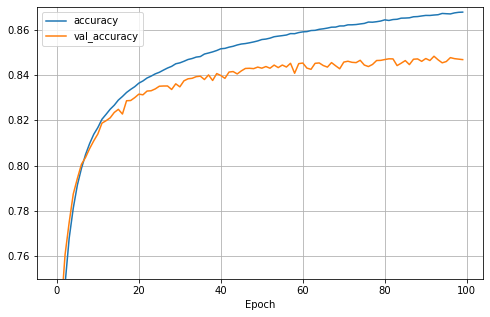

In [ ]:
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.75,0.87)
plt.xlabel('Epoch')
plt.show()

#### Use sklearn grid search to find best activation function

In [ ]:
def build_mlp(activation_function='relu'):
    """Build a Keras MLP for 62 class classification with desired parameters."""
    
    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    model.add(keras.layers.Dense(256,activation=activation_function))
    model.add(keras.layers.Dense(128,activation=activation_function))
    model.add(keras.layers.Dense(62, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   metrics=["accuracy"])
    return model

# Create a KerasClassifier object which works with sklearn grid searches
keras_classifier = KerasClassifier(build_mlp,
                                    epochs=1,
                                   
                                    activation_function = 'relu'
                                  
                                    )

param_grid = {'activation_function': ['relu','sigmoid','tanh']}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=10)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

Fitting 3 folds for each of 3 candidates, totalling 9 fits


2022-05-08 23:21:04.701795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
10906/10906 [==============================] - 18s 2ms/step - loss: 1.2481 - accuracy: 0.6644
Epoch 2/10
10906/10906 [==============================] - 15s 1ms/step - loss: 0.7766 - accuracy: 0.7657
Epoch 3/10
10906/10906 [==============================] - 16s 1ms/step - loss: 0.6616 - accuracy: 0.7924
Epoch 4/10
10906/10906 [==============================] - 16s 2ms/step - loss: 0.6006 - accuracy: 0.8077
Epoch 5/10
10906/10906 [==============================] - 15s 1ms/step - loss: 0.5614 - accuracy: 0.8165
Epoch 6/10
10906/10906 [==============================] - 16s 1ms/step - loss: 0.5334 - accuracy: 0.8237
Epoch 7/10
10906/10906 [==============================] - 15s 1ms/step - loss: 0.5127 - accuracy: 0.8285
Epoch 8/10
10906/10906 [==============================] - 14s 1ms/step - loss: 0.4957 - accuracy: 0.8326
Epoch 9/10
10906/10906 [==============================] - 14s 1ms/step - loss: 0.4821 - accuracy: 0.8363
Epoch 10/10
5453/5453 [==============================] 

In [ ]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.83022 (+/-0.002) for {'activation_function': 'relu'}
0.72214 (+/-0.001) for {'activation_function': 'sigmoid'}
0.82714 (+/-0.000) for {'activation_function': 'tanh'}
Best parameters:  {'activation_function': 'relu'}


#### Use sklearn grid search to choose the best optimizer

In [ ]:
def build_mlp():
    """Build a Keras MLP for 62 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    model.add(keras.layers.Dense(256,activation='relu'))
    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(62, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   metrics=["accuracy"])
    return model

# Create a KerasClassifier object which works with sklearn grid searches
keras_classifier = KerasClassifier(build_mlp,epochs=1)
param_grid = {'optimizer': ['RMSprop', 'Adam'],"optimizer__lr": [0.01,0.001,0.0001]}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=20)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Epoch 1/20
10906/10906 [==============================] - 17s 2ms/step - loss: 1.2682 - accuracy: 0.6623
Epoch 2/20
10906/10906 [==============================] - 16s 1ms/step - loss: 0.7834 - accuracy: 0.7647
Epoch 3/20
10906/10906 [==============================] - 15s 1ms/step - loss: 0.6635 - accuracy: 0.7931
Epoch 4/20
10906/10906 [==============================] - 14s 1ms/step - loss: 0.6007 - accuracy: 0.8081
Epoch 5/20
10906/10906 [==============================] - 14s 1ms/step - loss: 0.5613 - accuracy: 0.8172
Epoch 6/20
10906/10906 [==============================] - 14s 1ms/step - loss: 0.5333 - accuracy: 0.8240
Epoch 7/20
10906/10906 [==============================] - 14s 1ms/step - loss: 0.5127 - accuracy: 0.8286
Epoch 8/20
10906/10906 [==============================] - 14s 1ms/step - loss: 0.4960 - accuracy: 0.8330
Epoch 9/20
10906/10906 [==============================] - 15s 1ms/step - loss: 0.4828 - accuracy: 0.

In [ ]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.83959 (+/-0.003) for {'optimizer': 'RMSprop', 'optimizer__lr': 0.01}
0.83923 (+/-0.004) for {'optimizer': 'RMSprop', 'optimizer__lr': 0.001}
0.83904 (+/-0.005) for {'optimizer': 'RMSprop', 'optimizer__lr': 0.0001}
0.83980 (+/-0.004) for {'optimizer': 'Adam', 'optimizer__lr': 0.01}
0.83987 (+/-0.004) for {'optimizer': 'Adam', 'optimizer__lr': 0.001}
0.84039 (+/-0.003) for {'optimizer': 'Adam', 'optimizer__lr': 0.0001}
Best parameters:  {'optimizer': 'Adam', 'optimizer__lr': 0.0001}


In [9]:
def build_mlp(bn = True):
    """Build a Keras MLP for 62 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    model.add(keras.layers.Dense(256,activation='relu'))
    if bn == True:
      model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(62, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   metrics=["accuracy"])
    return model

# Create a KerasClassifier object which works with sklearn grid searches
keras_classifier = KerasClassifier(build_mlp,epochs=1,bn = True)
param_grid = {'bn': [True, False]}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=20)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/20
10906/10906 [==============================] - 58s 5ms/step - loss: 0.9642 - accuracy: 0.7249
Epoch 2/20
10906/10906 [==============================] - 54s 5ms/step - loss: 0.6396 - accuracy: 0.7950
Epoch 3/20
10906/10906 [==============================] - 54s 5ms/step - loss: 0.5689 - accuracy: 0.8118
Epoch 4/20
10906/10906 [==============================] - 51s 5ms/step - loss: 0.5307 - accuracy: 0.8214
Epoch 5/20
10906/10906 [==============================] - 50s 5ms/step - loss: 0.5065 - accuracy: 0.8274
Epoch 6/20
10906/10906 [==============================] - 49s 5ms/step - loss: 0.4865 - accuracy: 0.8324
Epoch 7/20
10906/10906 [==============================] - 49s 5ms/step - loss: 0.4731 - accuracy: 0.8360
Epoch 8/20
10906/10906 [==============================] - 49s 4ms/step - loss: 0.4605 - accuracy: 0.8393
Epoch 9/20
10906/10906 [==============================] - 50s 5ms/step - loss: 0.4502 - accuracy: 0.8

In [10]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.84237 (+/-0.002) for {'bn': True}
0.84003 (+/-0.003) for {'bn': False}
Best parameters:  {'bn': True}


#### View current model performance

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')
])

# Compile model with loss, optimiser, and metrics
opt = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer=opt,
                                   metrics=["accuracy"])

# Train the model for 30 epochs with batch size 128
batch_size = 128
epochs = 30
history_2 = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, y_val))
import pandas as pd
accuracies = pd.DataFrame(history_2.history)[['accuracy','val_accuracy']]

Epoch 1/30
4090/4090 [==============================] - 20s 5ms/step - loss: 1.1894 - accuracy: 0.6801 - val_loss: 0.8191 - val_accuracy: 0.7581
Epoch 2/30
4090/4090 [==============================] - 16s 4ms/step - loss: 0.7421 - accuracy: 0.7765 - val_loss: 0.6792 - val_accuracy: 0.7902
Epoch 3/30
4090/4090 [==============================] - 19s 5ms/step - loss: 0.6430 - accuracy: 0.7996 - val_loss: 0.6160 - val_accuracy: 0.8055
Epoch 4/30
4090/4090 [==============================] - 12s 3ms/step - loss: 0.5897 - accuracy: 0.8119 - val_loss: 0.5783 - val_accuracy: 0.8138
Epoch 5/30
4090/4090 [==============================] - 13s 3ms/step - loss: 0.5550 - accuracy: 0.8195 - val_loss: 0.5481 - val_accuracy: 0.8220
Epoch 6/30
4090/4090 [==============================] - 12s 3ms/step - loss: 0.5301 - accuracy: 0.8255 - val_loss: 0.5349 - val_accuracy: 0.8228
Epoch 7/30
4090/4090 [==============================] - 12s 3ms/step - loss: 0.5111 - accuracy: 0.8300 - val_loss: 0.5179 - val_ac

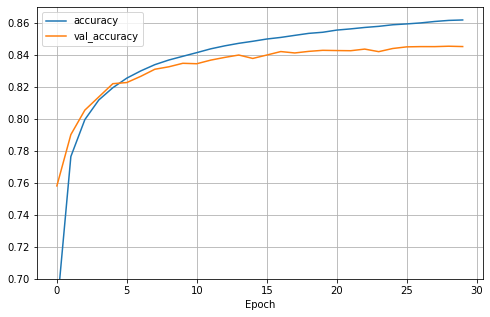

In [11]:
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.7,0.87)
plt.xlabel('Epoch')
plt.show()

#### Use dropout to regularize the model

In [ ]:
def build_mlp(drop_rate = 0.0):
    """Build a Keras MLP for 64 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    model.add(keras.layers.Dense(256,activation='relu'))
    model.add( keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(62, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   metrics=["accuracy"])
    return model

# Create a KerasClassifier object which works with sklearn grid searches
keras_classifier = KerasClassifier(build_mlp,epochs=1,drop_rate = 0.0)
param_grid = {'drop_rate': [0.1,0.2]}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=20)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

In [8]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.84274 (+/-0.003) for {'drop_rate': 0.1}
0.84054 (+/-0.003) for {'drop_rate': 0.2}
Best parameters:  {'drop_rate': 0.1}


#### Summary

In [7]:
time_start =time.time()
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')
])

# Compile model with loss, optimiser, and metrics
opt = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer=opt,
                                   metrics=["accuracy"])

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto'
)

# Train the model for 30 epochs with batch size 128
batch_size = 128
epochs = 30
history = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, y_val),
                    callbacks = [early_stop_cb])

time_end=time.time()
time_c =time_end - time_start
print('time cost',time_c,'s')

2022-05-20 16:51:09.185605: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
4090/4090 [==============================] - 37s 8ms/step - loss: 1.2485 - accuracy: 0.6637 - val_loss: 0.8282 - val_accuracy: 0.7545
Epoch 2/30
4090/4090 [==============================] - 26s 6ms/step - loss: 0.7874 - accuracy: 0.7629 - val_loss: 0.6768 - val_accuracy: 0.7894
Epoch 3/30
4090/4090 [==============================] - 24s 6ms/step - loss: 0.6782 - accuracy: 0.7883 - val_loss: 0.6050 - val_accuracy: 0.8071
Epoch 4/30
4090/4090 [==============================] - 33s 8ms/step - loss: 0.6198 - accuracy: 0.8025 - val_loss: 0.5637 - val_accuracy: 0.8161
Epoch 5/30
4090/4090 [==============================] - 36s 9ms/step - loss: 0.5820 - accuracy: 0.8115 - val_loss: 0.5363 - val_accuracy: 0.8231
Epoch 6/30
4090/4090 [==============================] - 31s 8ms/step - loss: 0.5550 - accuracy: 0.8177 - val_loss: 0.5165 - val_accuracy: 0.8273
Epoch 7/30
4090/4090 [==============================] - 24s 6ms/step - loss: 0.5347 - accuracy: 0.8226 - val_loss: 0.5016 - val_ac

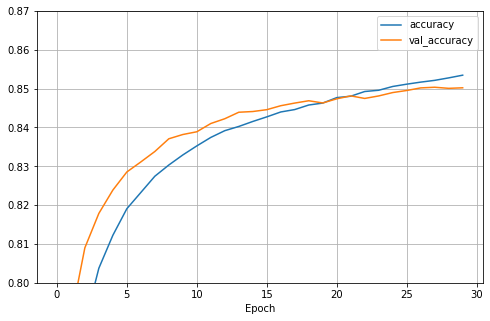

In [15]:
accuracies = pd.DataFrame(history.history)[['accuracy','val_accuracy']]

accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,0.87)
plt.xlabel('Epoch')
plt.show()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 62)                7998      
                                                                 
Total params: 241,854
Trainable params: 241,854
Non-trainable params: 0
_________________________________________________________________


## Using the final model do predict on test set

In [7]:
loss,accuracy = model.evaluate(X_test_norm,test_lab_raw)
print(f'Accuracy on test data: {accuracy:.4f}')

3636/3636 [==============================] - 5s 1ms/step - loss: 0.4228 - accuracy: 0.8511
Accuracy on test data: 0.8511


#### Compare prediction and true label

Show the prediction and true label of the first 10 data

In [9]:
X_test_sample = X_test_norm
y_proba = model.predict(X_test_sample).round(2)
y_pred = np.argmax(y_proba, axis = -1)
print('Model prediction: ',y_pred[:10])
print('True label: ',test_lab_raw[:10])

Model prediction:  [ 1 36  0  3 33 30 24 40  5  8]
True label:  [18. 36.  0.  3. 33. 30. 24. 40.  5.  8.]


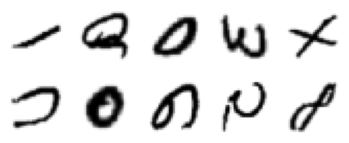

In [ ]:
# plot the first 10 test data
plot_examples(X_test_sample,n_rows =2, n_cols =5)  

#### Show accuracy, precision, recall, F1 score of the prediction 

In [10]:
print('The accuracy socre of MLP model is: {:.2f} '.format(accuracy_score(test_lab_raw,y_pred)))
print('The precision socre of MLP model is: {:.2f} '.format(precision_score(test_lab_raw,y_pred,average='weighted')))
print('The recall socre of MLP model is: {:.2f} '.format(recall_score(test_lab_raw,y_pred,average='weighted')))
print('The F1 socre of MLP model is: {:.2f} '.format(f1_score(test_lab_raw,y_pred,average='weighted')))

The accuracy socre of MLP model is: 0.85 
The precision socre of MLP model is: 0.84 
The recall socre of MLP model is: 0.85 
The F1 socre of MLP model is: 0.84 


#### Plot confusion mactrix

Plot confusion mactrix to observe the classification performance of the model for some categories.

Text(0.5, 1.0, 'Confusion matrix')

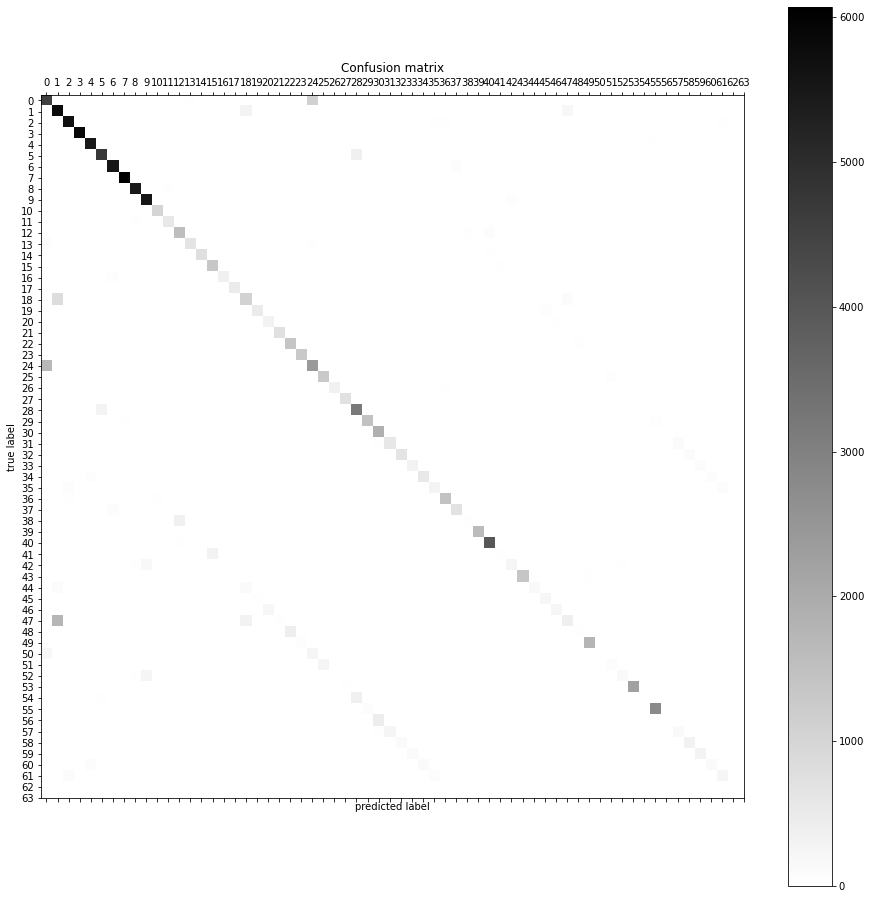

In [ ]:
%matplotlib inline
def cm_to_inch(value):
    return value/2.54

matfig = plt.figure(figsize=(cm_to_inch(40),cm_to_inch(40)))
plt.matshow(confusion_matrix(test_lab_raw, y_pred), cmap=plt.cm.binary, interpolation='nearest',fignum=matfig.number)
plt.colorbar()
plt.xticks(range(64))
plt.yticks(range(64))
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Confusion matrix')